## Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Dependencies to Install

In [2]:
!pip install PyMuPDF Pillow
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 9.4 MB/s eta 0:00:00


In [3]:
# computer vision
import fitz
import cv2
from google.colab.patches import cv2_imshow

# miscellaneous
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import random

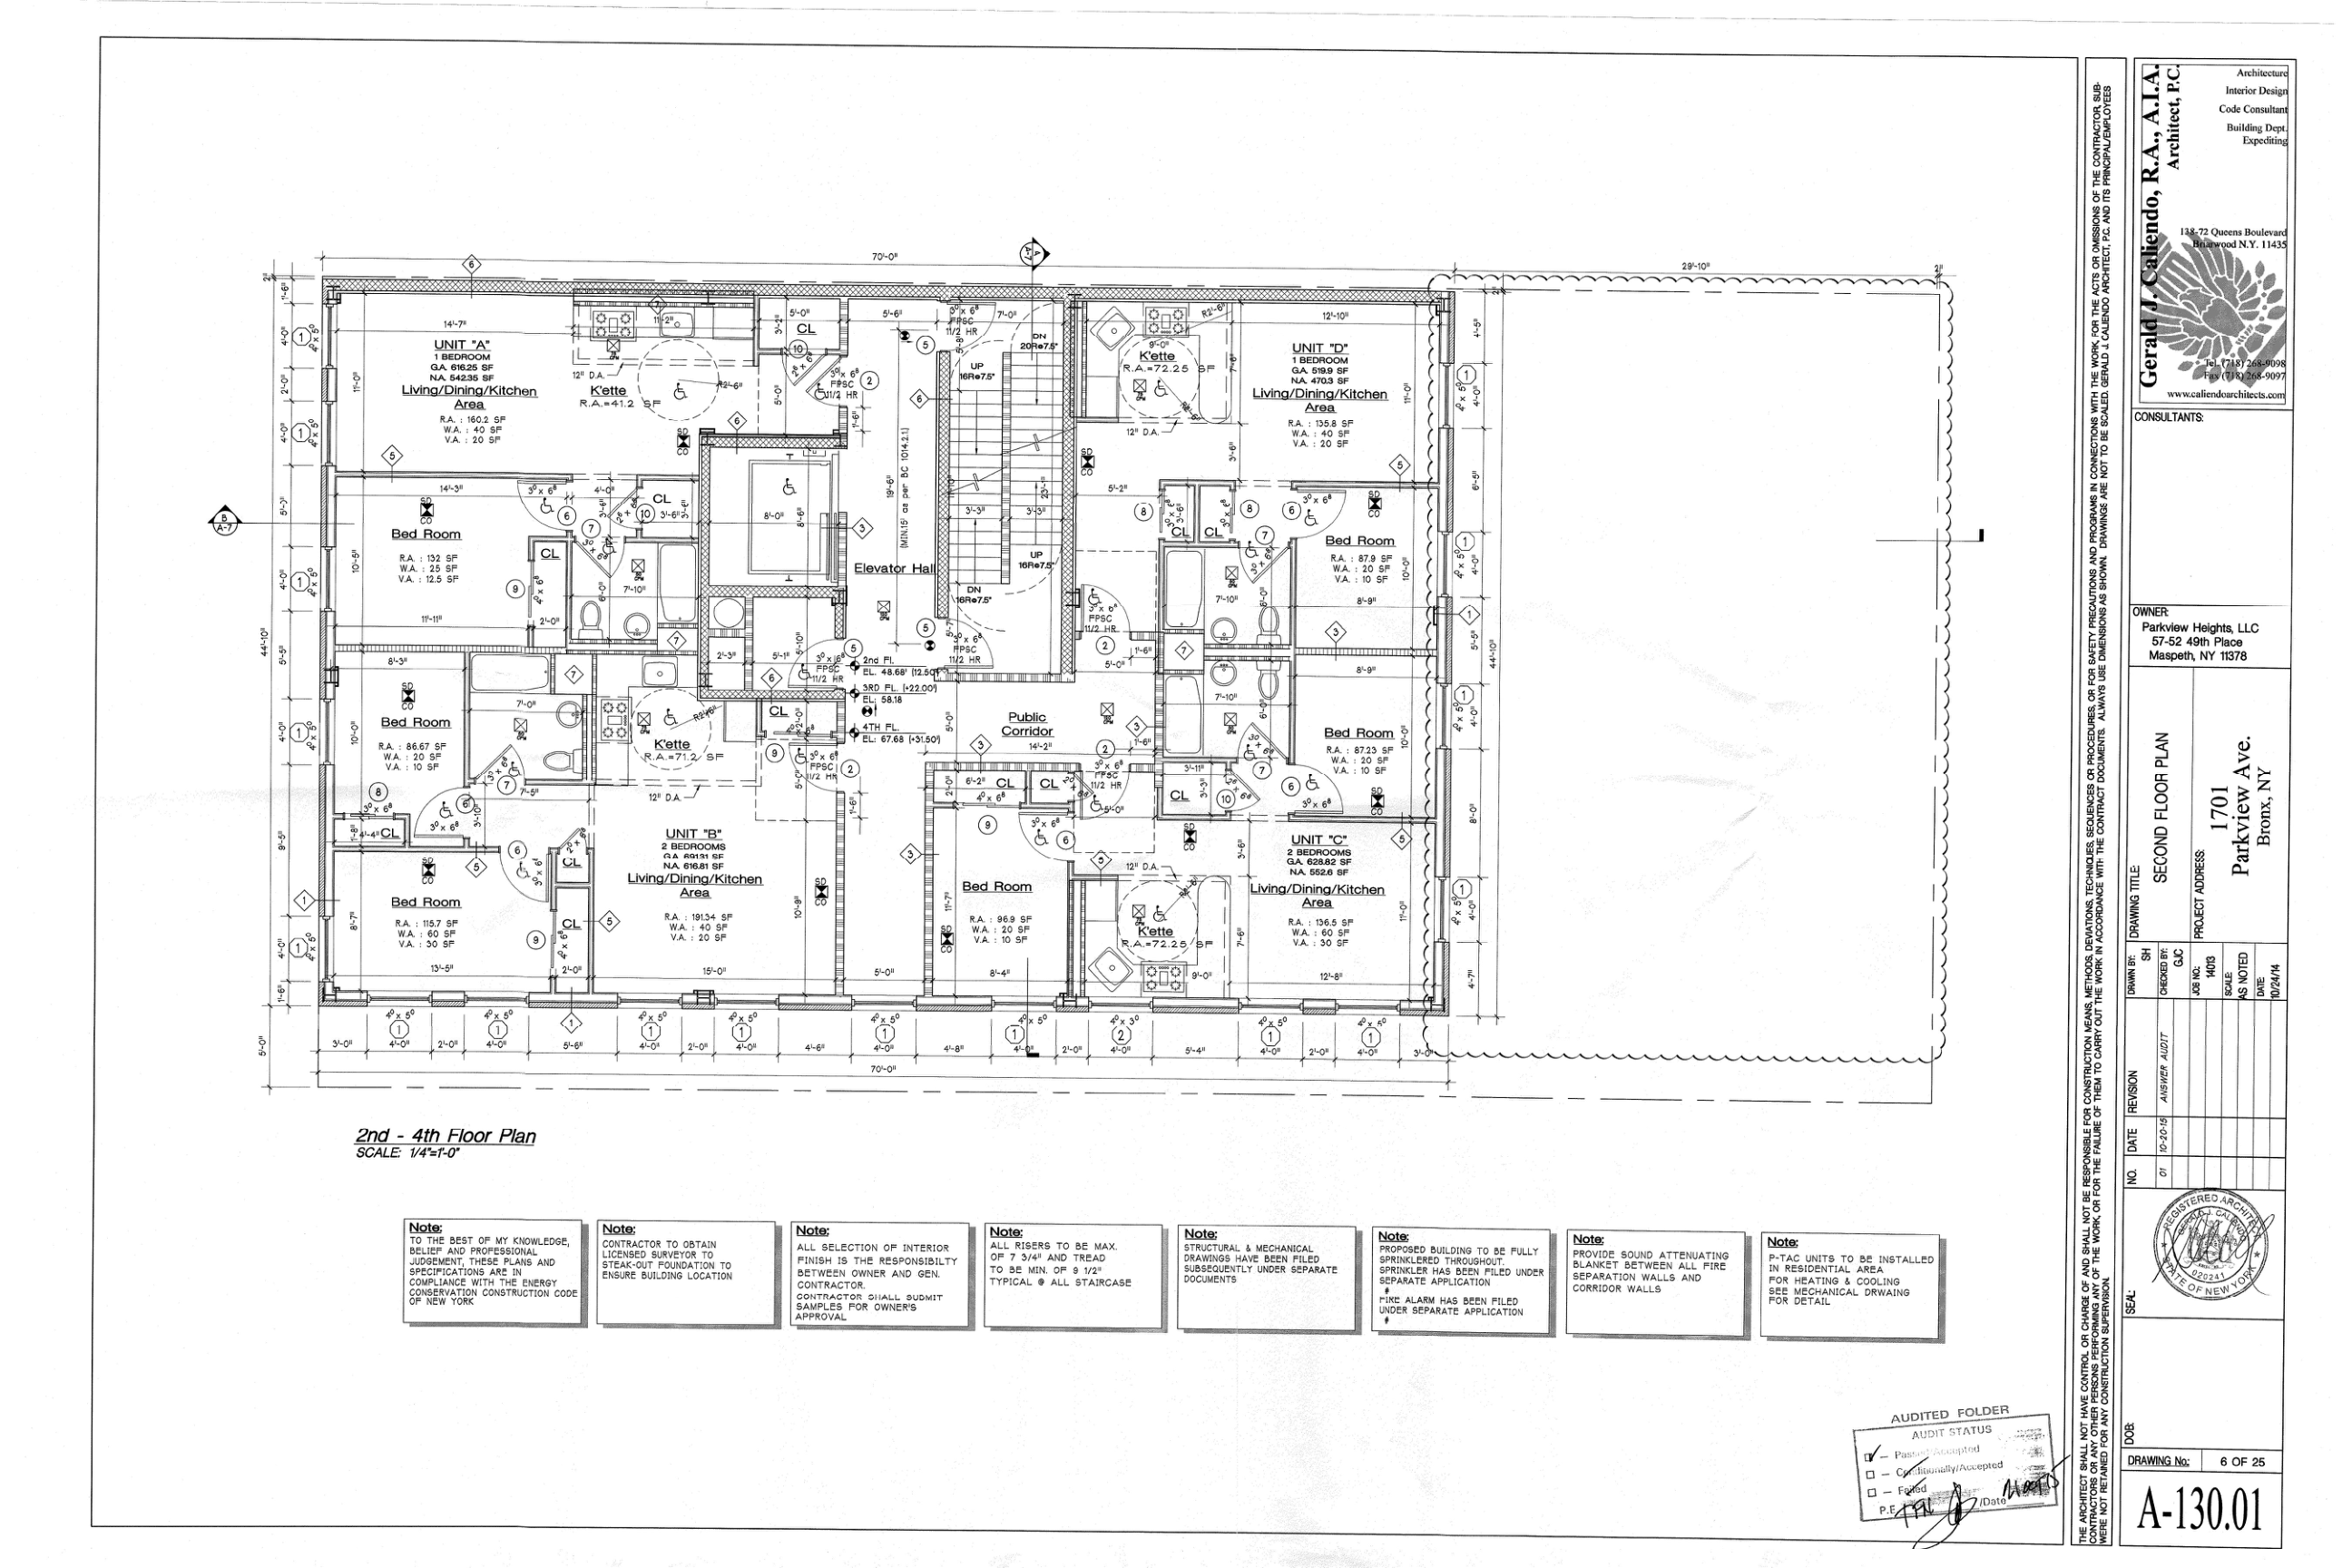

In [42]:
# Load the image using OpenCV
img = cv2.imread("/content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Architectural/page_6.png")

'''
arch: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Architectural/page_6.png

mech: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Mechanical/page_50.png

struct: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Structural/page_35.png

plumbing: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Plumbing/page_62.png
'''

# Display the image using cv2_imshow
cv2_imshow(img)

# Floorplan Labeling

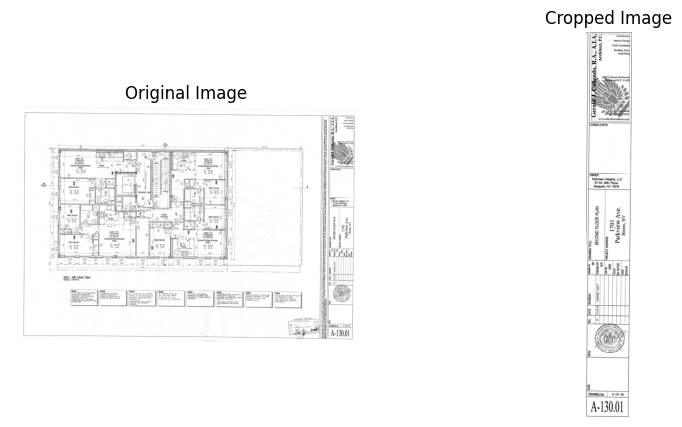

In [43]:
def extract_contour_by_index(img, index=0):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3,3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    return sorted_contours[index]

# Get bounding rectangle for the extracted contour
sidebar_image = extract_contour_by_index(img, index=1)
x, y, w, h = cv2.boundingRect(sidebar_image)

# Crop the image based on the contour
cropped_image = img[y:y + h, x:x + w]
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Plot the original and cropped images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cropped_image_rgb)
plt.title("Cropped Image")
plt.axis("off")
plt.show()

Sidebar contour detection seems to work properly on 3 out of 4 floorplan types. Structural type has difficulty detecting sidebar since its formatted differently. Does cv2 template matching pick up on that, and what's the fix? How are the algorithms still able to label the floorplans as structural given that your algorithm specifically looks for contours?

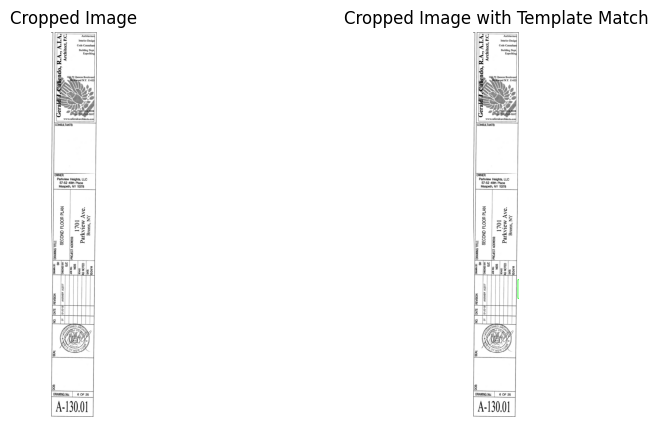

In [63]:
# preprocess template image for matching
sample_template = cv2.imread('/content/Arch-general-label.png', 0)
template_image = sample_template.astype(np.uint8)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
template_image = clahe.apply(template_image)

# Perform template matching
gray_cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
res = cv2.matchTemplate(gray_cropped_image, template_image, cv2.TM_CCOEFF_NORMED)
_, max_val, max_loc, _ = cv2.minMaxLoc(res)

# Clone the cropped image to keep the original for the first plot
cropped_image_with_match = cropped_image_rgb.copy()

# Draw rectangle around the matched template
top_left = max_loc
bottom_right = (top_left[0] + template_image.shape[1], top_left[1] + template_image.shape[0])
cv2.rectangle(cropped_image_with_match, top_left, bottom_right, (0, 255, 0), 2)

# Convert images for plotting in matplotlib
cropped_image_with_match_rgb = cv2.cvtColor(cropped_image_with_match, cv2.COLOR_BGR2RGB)

# Plot the original cropped image and the cropped image with template match
plt.figure(figsize=(10, 5))

# Plot cropped image withoCan you ut template match
plt.subplot(1, 2, 1)
plt.imshow(cropped_image_rgb)
plt.title("Cropped Image")
plt.axis("off")

# Plot cropped image with template match
plt.subplot(1, 2, 2)
plt.imshow(cropped_image_with_match_rgb)
plt.title("Cropped Image with Template Match")
plt.axis("off")

plt.show()

# Outer Wall Detection

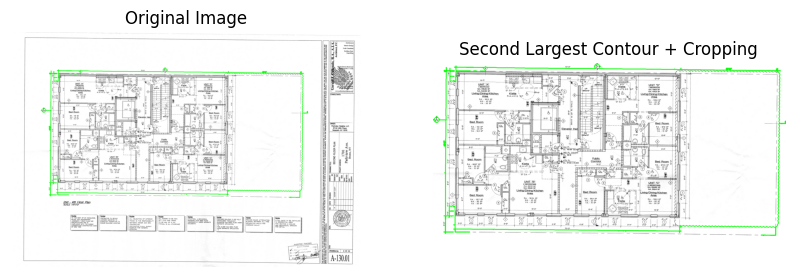

In [44]:
# Extract largest contour (index=0)
largest_contour = extract_contour_by_index(img, index=0)

# Get bounding rectangle for the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)
cropped_image = img[y:y + h - 10, x:x + w - 10]

# Extract the second largest contour within the cropped image
second_largest_contour = extract_contour_by_index(cropped_image, index=0)
x, y, w, h = cv2.boundingRect(second_largest_contour)

# Draw the second largest contour (outer boundary)
output_image = img.copy()
cv2.drawContours(cropped_image, [second_largest_contour], -1, (0, 255, 0), 3)  # Draw in green

# Plot the original image and the cropped image with the second largest contour
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Cropped Image with Second Largest Contour
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped_image[y:y + h, x:x + w], cv2.COLOR_BGR2RGB))
plt.title("Second Largest Contour + Cropping")
plt.axis("off")

plt.show()